# **Trabalho Prático 3**
## *Transfer Learning*

### ***Imports* Globais**

<br/>

Todos os *imports* são feitos aqui dado que todo o trabalho foi pensado para funcionar em modo Classe Python.

In [0]:
import os
import pathlib
import random
import shutil

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!wget -c https://nextcloudpt.duckdns.org/index.php/s/T2dEg8FZwTNzyKx/download -O train.zip
!unzip -n train.zip -d .

### **Definição da Classe Python catsAndDogs e de todos os seus métodos**

<br/>

Classe que terá todas as definições necessárias para criar, treinar e posteriormente avaliar os resultados da rede.

Para este Trabalho Prático escolhou-se o *deep learning model* NASNetMobile, dado que notamos que é o que apresenta melhores resultados em termos de *accuracy*. Esta rede contém os pesos já treinados com a imagenet.

**Com o modelo escolhido, a ideia passou por:**

**1. Efetuar 3 treinos distintos baseados nos três tipos de redes/modelos seguintes:**
- Treinar a rede NASNetMobile sem usar os pesos da imagenet;
- Treinar a rede NASNetMobile a usar os pesos da imagenet;
- Treinar a rede NASNetMobile a usar os pesos da imagenet mas congelando os *layers* convolucionais.

**2. Usar três tipos de *datasets* de treino para cada um destes. O *dataset* de teste mantém-se sempre com 1000 imagens para os *cats* e 1000 imagens para os *dogs*:**
- *Dataset* de treino com 23000 imagens
- *Dataset* de treino com 2500 imagens
- *Dataset* de treino com 250 imagens

In [0]:
class catsAndDogs:

  # Método que define/inicializa todas as variáveis globais e usadas ao longo de toda a Classe.
  def __init__(self):

    self.NCLASSES = 2
    self.HEIGHT = 224
    self.WIDTH = 224
    self.NUM_CHANNELS = 3
    self.BATCH_SIZE = 32
    self.AUTOTUNE = None

    self.baseModel1 = self.baseModel2 = self.baseModel3 = None

    self.model1 = self.model2 = self.model3 = None

    self.classNames = None

    self.dataset = self.datasetHome = None

    self.trainDataset = self.validationDataset = self.testDataset = None

    self.trainDatasetSize = self.validationDatasetSize = self.dataset_length = None

    self.historyModel1 = {}
    self.historyModel2 = {}
    self.historyModel3 = {}

  # Método que define os três diferentes modelos/redes para treino.
  def loadModel(self):

    # Retira-se a cabeça da rede ao defenir o "include_top" como False.
    self.baseModel1 = tf.keras.applications.nasnet.NASNetMobile(include_top=False, weights=None, input_shape=(self.HEIGHT, self.WIDTH, self.NUM_CHANNELS))
    self.baseModel2 = tf.keras.applications.nasnet.NASNetMobile(include_top=False, weights='imagenet', input_shape=(self.HEIGHT, self.WIDTH, self.NUM_CHANNELS))
    self.baseModel3 = tf.keras.applications.nasnet.NASNetMobile(include_top=False, weights='imagenet', input_shape=(self.HEIGHT, self.WIDTH, self.NUM_CHANNELS))

    self.baseModel1.trainable = True
    self.baseModel2.trainable = True
    self.baseModel3.trainable = False

  # Método que manipula as camadas dos três diferentes modelos e aplica outras definições.
  def changeLayers(self):

    x1 = self.baseModel1.output
    x1 = layers.GlobalAveragePooling2D()(x1)
    x1 = layers.Dense(4096, activation='relu')(x1)
    x1 = layers.Dense(2, activation='softmax')(x1)

    x2 = self.baseModel2.output
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dense(4096, activation='relu')(x2)
    x2 = layers.Dense(2, activation='softmax')(x2)

    x3 = self.baseModel3.output
    x3 = layers.GlobalAveragePooling2D()(x3)
    x3 = layers.Dense(4096, activation='relu')(x3)
    x3 = layers.Dense(2, activation='softmax')(x3)

    self.model1 = models.Model(inputs=self.baseModel1.input, outputs=x1)
    self.model2 = models.Model(inputs=self.baseModel2.input, outputs=x2)
    self.model3 = models.Model(inputs=self.baseModel3.input, outputs=x3)

  # Método que obtém o label.
  def getLabel(self, file_path):

    # Convert the path to a list of path components.
    parts = tf.strings.split(file_path, os.path.sep)

    # The second to last is the class-directory.
    return parts[-2] == self.classNames

  # Método que faz o decode da imagem.
  def decodeImage(self, img):

    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_png(img, channels=3)

    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize the image to the desired size.
    return tf.image.resize(img, [self.WIDTH, self.HEIGHT])

  # Método que obtém os bytes e o label.
  def getBytesAndLabel(self, file_path):

    label = self.getLabel(file_path)

    # Load the raw data from the file as a string.
    img = tf.io.read_file(file_path)
    img = self.decodeImage(img)

    return img, label

  # Método que cria as folders de Treino e Teste prontas a serem povoadas.
  def createFoldersTrainTest(self):

    # Create Directories
    self.datasetHome = 'dataset_dogs_vs_cats/'
    subdirs = ['train/', 'test/']

    for subdir in subdirs:
        # Create Label Subdirectories
        labeldirs = ['dogs/', 'cats/']

        for labldir in labeldirs:
            newdir = self.datasetHome + subdir + labldir
            os.makedirs(newdir, exist_ok=True)

  # Método que limpa a pasta de Treino por completo.
  def clearTrainFolder(self):

    for file in os.listdir(self.datasetHome + "train/cats"):
        os.remove(self.datasetHome + "train/cats/" + file)
    for file in os.listdir(self.datasetHome + "/train/dogs"):
        os.remove(self.datasetHome + "train/dogs/" + file)

  # Método que faz o povoamento das pastas de Treino e Teste.
  # Coloca obrigatoriamente 1000 em cada subpasta da pasta de Teste.
  # As restantes são mandadas para a pasta de Treino.
  def fillFolders(self, datasetCount):
      
    # Seed Random Number Generator.
    random.seed(1)

    # Copy Training Dataset Images into Subdirectories.
    src_directory = 'train/'

    currTestCats = currTestDogs = currTrainCats = currTrainDogs = 0

    for file in os.listdir(src_directory):

        src = src_directory + '/' + file

        if file.startswith('cat'):

            if currTestCats < 1000:
                dst_dir = 'test/'
                currTestCats += 1

            elif currTrainCats < int(datasetCount / 2):
                dst_dir = 'train/'
                currTrainCats += 1

            else:
                continue

            dst = self.datasetHome + dst_dir + 'cats/'  + file
            shutil.copyfile(src, dst)
            
        elif file.startswith('dog'):

            if currTestDogs < 1000:
                dst_dir = 'test/'
                currTestDogs += 1

            elif currTrainDogs < int(datasetCount / 2):
                dst_dir = 'train/'
                currTrainDogs += 1

            else:
                continue

            dst = self.datasetHome + dst_dir + 'dogs/'  + file
            shutil.copyfile(src, dst)

  # Método que define o dataset de Treino.
  def defineDatasetTrain(self):

    data_dir = pathlib.Path(self.datasetHome + 'train/')

    self.classNames = np.array(os.listdir(data_dir))
    self.classNames

    self.AUTOTUNE = tf.data.experimental.AUTOTUNE

    listset = tf.data.Dataset.list_files(self.datasetHome + "train/*/*.jpg")
    self.dataset = listset.map(self.getBytesAndLabel, num_parallel_calls = self.AUTOTUNE)

    self.dataset_length = [i for i,_ in enumerate(self.dataset)][-1] + 1
    print("Total images in Train Dataset: ", self.dataset_length)

  # Método que faz o split do dataset de Treino, criando o de Treino e Validação.
  def splitDatasetTrainValidation(self):

    self.dataset = self.dataset.prefetch(buffer_size=self.AUTOTUNE)
    #self.dataset = self.dataset.batch(batch_size=self.BATCH_SIZE)
    self.dataset = self.dataset.repeat()

    self.trainDatasetSize = int(self.dataset_length * 0.8)
    self.validationDatasetSize = int(self.dataset_length * 0.2)

    self.trainDataset = self.dataset.take(self.trainDatasetSize)
    self.trainDataset = self.trainDataset.shuffle(buffer_size = self.trainDatasetSize)
    self.trainDataset = self.trainDataset.batch(batch_size = self.BATCH_SIZE)
    self.trainDataset = self.trainDataset.repeat();
    self.trainDataset.class_mode = 'binary'

    self.validationDataset = self.dataset.skip(self.trainDatasetSize)
    self.validationDataset = self.validationDataset.batch(batch_size = self.BATCH_SIZE)
    self.validationDataset = self.validationDataset.repeat();
    self.validationDataset.class_mode = 'binary'

  # Método que define o dataset de Teste.
  def defineDatasetTest(self):

    self.testDataset = tf.data.Dataset.list_files(self.datasetHome + "test/*/*.jpg")
    self.testDataset = self.testDataset.map(self.getBytesAndLabel, num_parallel_calls = self.AUTOTUNE)

    testDataset_length = [i for i,_ in enumerate(self.testDataset)][-1] + 1
    print("Total images in Test Dataset: ", testDataset_length)

    self.testDataset = self.testDataset.batch(batch_size = self.BATCH_SIZE)
    self.testDataset.class_mode = 'binary'
        
  # Método que treina os três modelos/redes de uma vez.
  # Este método é executado por cada dataset diferente.
  def trainModel(self):

    self.model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
    self.historyModel1[self.dataset_length] = self.model1.fit(self.trainDataset, epochs=5, steps_per_epoch=self.trainDatasetSize/self.BATCH_SIZE, validation_data = self.validationDataset, validation_steps= self.validationDatasetSize/self.BATCH_SIZE)

    self.model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
    self.historyModel2[self.dataset_length] = self.model2.fit(self.trainDataset, epochs=5, steps_per_epoch=self.trainDatasetSize/self.BATCH_SIZE, validation_data = self.validationDataset, validation_steps= self.validationDatasetSize/self.BATCH_SIZE)

    self.model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
    self.historyModel3[self.dataset_length] = self.model3.fit(self.trainDataset, epochs=5, steps_per_epoch=self.trainDatasetSize/self.BATCH_SIZE, validation_data = self.validationDataset, validation_steps= self.validationDatasetSize/self.BATCH_SIZE)

  # Método que faz o evalute do dataset de Teste.
  # Este método é executado por cada dataset diferente.
  def evaluateTest(self):

    self.model1.evaluate(self.testDataset)
    self.model2.evaluate(self.testDataset)
    self.model3.evaluate(self.testDataset)

  # Método que apresenta os resultados em modo plot.
  # Este método é executado por cada dataset diferente.
  def plotsResults(self):

    print(self.historyModel1[self.dataset_length].history.keys())
    plt.plot(self.historyModel1[self.dataset_length].history['categorical_accuracy'])
    plt.plot(self.historyModel1[self.dataset_length].history['val_categorical_accuracy'])
    plt.title('Model 1 Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print(self.historyModel2[self.dataset_length].history.keys())
    plt.plot(self.historyModel2[self.dataset_length].history['categorical_accuracy'])
    plt.plot(self.historyModel2[self.dataset_length].history['val_categorical_accuracy'])
    plt.title('Model 2 Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print(self.historyModel3[self.dataset_length].history.keys())
    plt.plot(self.historyModel3[self.dataset_length].history['categorical_accuracy'])
    plt.plot(self.historyModel3[self.dataset_length].history['val_categorical_accuracy'])
    plt.title('Model 3 Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## **Criação da Classe Python e execução de todos os passos para criar, treinar e avaliar os três tipos de modelos/rede para cada *dataset***

<br/>

### Criação de uma instância da Classe Python.

In [0]:
myCatsAndDogs = catsAndDogs()

### Criação/load dos três tipos de modelos a ser usados.

In [0]:
myCatsAndDogs.loadModel()

19996672/19993432 [==============================] - 0s 0us/step


### Aplicar as manipulações necessárias às camadas de cada uma destas três redes.

In [0]:
myCatsAndDogs.changeLayers()

### Criar as pastas necessárias para os *dataset* de Treino e Teste.

In [0]:
myCatsAndDogs.createFoldersTrainTest()

### Começar os processos de Treino e Teste.

#### 1. *Dataset* com 23000 imagens

- Povoar as pastas dos *datasets* de Treino e Teste;
- Fazer o *split* do Treino e da Validação;
- Treinar os três modelos para este *dataset*;
- Fazer o *evalute* do *dataset* de Teste;
- Obter os resultados dos *plots* para cada um desses modelos.

In [0]:
myCatsAndDogs.fillFolders(23000)
myCatsAndDogs.defineDatasetTrain()
myCatsAndDogs.splitDatasetTrainValidation()
myCatsAndDogs.defineDatasetTest()

Total images in Train Dataset:  23000
Total images in Test Dataset:  2000


In [0]:
myCatsAndDogs.trainModel()

Epoch 1/5
575/575 [==============================] - 214s 372ms/step - loss: 0.6567 - categorical_accuracy: 0.6539 - val_loss: 3.9178 - val_categorical_accuracy: 0.5080
Epoch 2/5
575/575 [==============================] - 210s 366ms/step - loss: 0.4710 - categorical_accuracy: 0.7753 - val_loss: 3.0649 - val_categorical_accuracy: 0.5197
Epoch 3/5
575/575 [==============================] - 210s 366ms/step - loss: 0.3656 - categorical_accuracy: 0.8373 - val_loss: 1.9261 - val_categorical_accuracy: 0.5974
Epoch 4/5
575/575 [==============================] - 210s 365ms/step - loss: 0.2874 - categorical_accuracy: 0.8760 - val_loss: 2.7287 - val_categorical_accuracy: 0.5388
Epoch 5/5
575/575 [==============================] - 211s 366ms/step - loss: 0.2365 - categorical_accuracy: 0.9022 - val_loss: 4.0594 - val_categorical_accuracy: 0.5237
Epoch 1/5
575/575 [==============================] - 215s 374ms/step - loss: 0.1101 - categorical_accuracy: 0.9608 - val_loss: 1.5448 - val_categorical_acc

In [0]:
myCatsAndDogs.evaluateTest()

63/63 [==============================] - 3s 51ms/step - loss: 0.0478 - categorical_accuracy: 0.9835


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


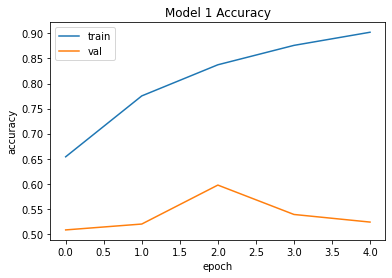

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


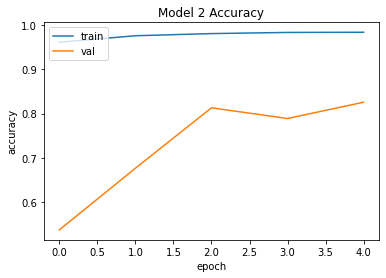

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


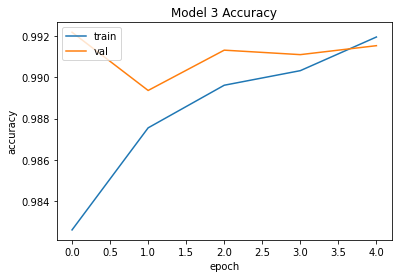

In [0]:
myCatsAndDogs.plotsResults()

#### 2. *Dataset* com 2500 imagens

- Fazer o *clean* da pasta de Treino para evitar ter sempre 23000 imagens;
- Povoar as pastas dos *datasets* de Treino. O de Teste já foi definido e é igual para este passo;
- Fazer o *split* do Treino e da Validação;
- Treinar os três modelos para este *dataset*;
- Fazer o *evalute* do *dataset* de Teste;
- Obter os resultados dos *plots* para cada um desses modelos.

In [0]:
myCatsAndDogs.clearTrainFolder()
myCatsAndDogs.fillFolders(2500)
myCatsAndDogs.defineDatasetTrain()
myCatsAndDogs.splitDatasetTrainValidation()

Total images in Train Dataset:  2500


In [0]:
myCatsAndDogs.trainModel()

63/62 [==============================] - 26s 417ms/step - loss: 0.2354 - categorical_accuracy: 0.8975 - val_loss: 2.6756 - val_categorical_accuracy: 0.5684
Epoch 2/5
63/62 [==============================] - 23s 358ms/step - loss: 0.1562 - categorical_accuracy: 0.9385 - val_loss: 3.0810 - val_categorical_accuracy: 0.5059
Epoch 3/5
63/62 [==============================] - 23s 360ms/step - loss: 0.1387 - categorical_accuracy: 0.9445 - val_loss: 4.1343 - val_categorical_accuracy: 0.5664
Epoch 4/5
63/62 [==============================] - 23s 358ms/step - loss: 0.1001 - categorical_accuracy: 0.9655 - val_loss: 3.8875 - val_categorical_accuracy: 0.5840
Epoch 5/5
63/62 [==============================] - 23s 359ms/step - loss: 0.1062 - categorical_accuracy: 0.9605 - val_loss: 4.1226 - val_categorical_accuracy: 0.5605
Epoch 1/5
63/62 [==============================] - 26s 415ms/step - loss: 0.0451 - categorical_accuracy: 0.9815 - val_loss: 340.6736 - val_categorical_accuracy: 0.4785
Epoch 2/5
63

In [0]:
myCatsAndDogs.evaluateTest()

63/63 [==============================] - 3s 51ms/step - loss: 0.0766 - categorical_accuracy: 0.9855


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


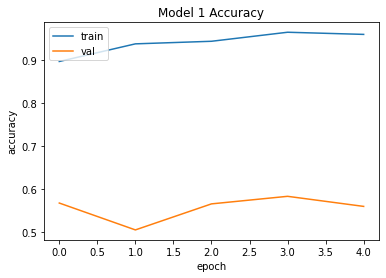

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


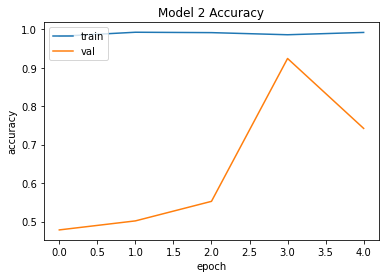

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


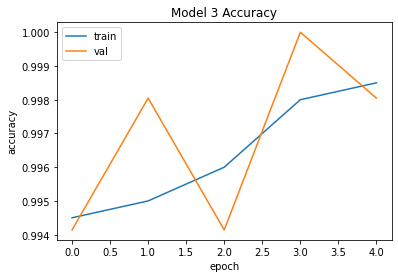

In [0]:
myCatsAndDogs.plotsResults()

#### 3. *Dataset* com 250 imagens

- Fazer o *clean* da pasta de Treino para evitar ter sempre 23000 imagens;
- Povoar as pastas dos *datasets* de Treino. O de Teste já foi definido e é igual para este passo;
- Fazer o *split* do Treino e da Validação;
- Treinar os três modelos para este *dataset*;
- Fazer o *evalute* do *dataset* de Teste;
- Obter os resultados dos *plots* para cada um desses modelos.

In [0]:
myCatsAndDogs.clearTrainFolder()
myCatsAndDogs.fillFolders(250)
myCatsAndDogs.defineDatasetTrain()
myCatsAndDogs.splitDatasetTrainValidation()

Total images in Train Dataset:  250


In [0]:
myCatsAndDogs.trainModel()

Epoch 1/5
7/6 [=================================] - 6s 859ms/step - loss: 0.0442 - categorical_accuracy: 0.9850 - val_loss: 6.0888 - val_categorical_accuracy: 0.5781
Epoch 2/5
7/6 [=================================] - 2s 304ms/step - loss: 0.1114 - categorical_accuracy: 0.9600 - val_loss: 3.9342 - val_categorical_accuracy: 0.6406
Epoch 3/5
7/6 [=================================] - 2s 304ms/step - loss: 0.0443 - categorical_accuracy: 0.9800 - val_loss: 3.7022 - val_categorical_accuracy: 0.5000
Epoch 4/5
7/6 [=================================] - 2s 304ms/step - loss: 0.1188 - categorical_accuracy: 0.9800 - val_loss: 4.1379 - val_categorical_accuracy: 0.5781
Epoch 5/5
7/6 [=================================] - 2s 303ms/step - loss: 0.0569 - categorical_accuracy: 0.9850 - val_loss: 3.6165 - val_categorical_accuracy: 0.5312
Epoch 1/5
7/6 [=================================] - 6s 827ms/step - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 48.4222 - val_categorical_accuracy: 0.8125
Epo

In [0]:
myCatsAndDogs.evaluateTest()

63/63 [==============================] - 3s 51ms/step - loss: 0.0773 - categorical_accuracy: 0.9865


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


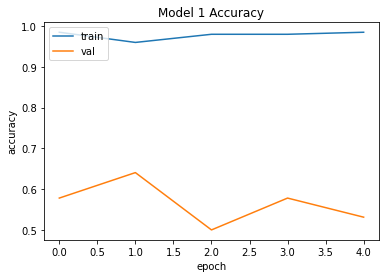

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


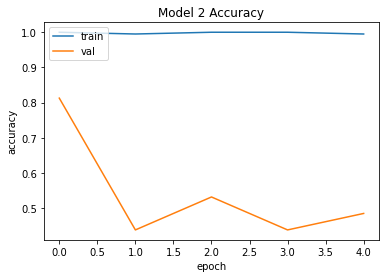

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


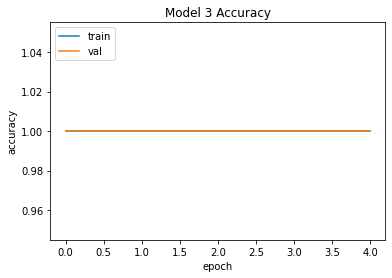

In [0]:
myCatsAndDogs.plotsResults()

## **Observações Finais**



### Resultados para a rede NASNetMobile sem usar os pesos imagenet

**Observe-se os resultados comparativos entre os três *datasets* para a rede NASNetMobile sem usar os pesos imagenet:**

| Tamanho/Número Imagens *Dataset* Treino | Resultados *Accuracy* |
| --------------------------------------- | --------------------- |
| 23000 imagens                           | 0.5265 ≅ 53%          |
| 2500 imagens                            | 0.5925 ≅ 60%          |
| 250 imagens                             | 0.5770 ≅ 60%          |


### Resultados para a rede NASNetMobile a usar os pesos imagenet

**Observe-se os resultados comparativos entre os três *datasets* para a rede NASNetMobile a usar os pesos imagenet:**

| Tamanho/Número Imagens *Dataset* Treino | Resultados *Accuracy* |
| --------------------------------------- | --------------------- |
| 23000 imagens                           | 0.8265 ≅ 83%          |
| 2500 imagens                            | 0.7260 ≅ 73%          |
| 250 imagens                             | 0.5000 ≅ 50%          |

### Resultados para a rede NASNetMobile a usar os pesos da imagenet mas congelando os *layers* convolucionais

**Observe-se os resultados comparativos entre os três *datasets* para a rede NASNetMobile a usar os pesos da imagenet mas congelando os *layers* convolucionais:**

| Tamanho/Número Imagens *Dataset* Treino | Resultados *Accuracy* |
| --------------------------------------- | --------------------- |
| 23000 imagens                           | 0.9835 ≅ 98%          |
| 2500 imagens                            | 0.9855 ≅ 99%          |
| 250 imagens                             | 0.9865 ≅ 99%          |



- O Modelo 3 é o melhor, como seria de esperar, dado que usa os pesos e congela as *layers* convolucionais;
- Nota-se uma diferença uma diferença significativa para o Modelo 2 em termos de tamanho de *dataset*, sendo o *dataset* maior aquele que apresenta melhores resultados de *accuracy*;
- Quanto ao uso do Modelo 1 não se nota grande diferença entre os três *datasets* treinados/testados.

**Note-se que apenas se testou para o valor de 5 epochs, podendo este influenciar nos resultados obtidos.**